# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
  1
 -1
 -1
  1

### We create a function to visualize the data

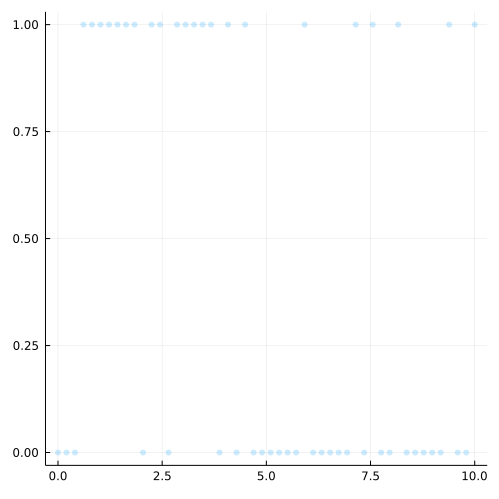

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.998347 seconds (1.85 M allocations: 98.311 MiB, 99.61% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.778001866401257, 0.6902792402504053, 0.6556274718980153, 0.7056196203668218, 0.8216813889994989, 0.9580471230270016, 1.0782378665953414, 1.1635236535247058, 1.2098831197674862, 1.223330374284654  …  0.9691406451953289, 1.01053223376374, 1.0393363270679188, 1.0454873873159802, 1.023816878652358, 0.9762336143050488, 0.9122640352101808, 0.8480487236674, 0.8013478819195795, 0.7847952802592528], θ = [0.23810908265068628, 0.24052446108124226, 0.24141373652912496, 0.2401187972829368, 0.236823102385742, 0.23248400934197255, 0.2282987629691981, 0.22515433232078602, 0.2233920478489906, 0.22287446471987524  …  0.2321109718505057, 0.23069456622505682, 0.2296868909797457, 0.22946944699936947, 0.23023200629808324, 0.23187097930487327, 0.23399281637526265, 0.23602141247260852, 0.23742838357551593, 0

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:26
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:46
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:50
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:22
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:54
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.9288195608749187, 1.0410270599046525, 1.0669328183819158, 0.9876239481083245, 0.819185582788919, 0.5735368549488207, 0.32647363773395954, 0.0822140542359151, -0.06817376264975405, -0.07580923650715998  …  -1.5050288010684219, -1.1040303227478605, -0.6734573975328457, -0.32826805228393396, -0.020583057069293198, 0.14211138330109752, 0.20055000316166993, 0.1863585355044421, 0.0998456138381898, -0.11806570268544556]]
 [[-0.3504837144903377, -0.33921220422790904, -0.14041380398115075, 0.18407862216657692, 0.5313492619577067, 0.9111887205231275, 1.1977901889374454, 1.341892641725922, 1.3811149509642913, 1.311154689678311  …  -1.0650129095323657, -0.8557965911044849, -0.7114528148401119, -0.6146121436414569, -0.5284524531791881, -0.4368901464725897, -0.3318926382128322, -0.2162583422740269, -0.087802784818994, -0.006798387922193727]]
 [[-0.27636875956535867, -0.4171299194331983, -0.4668384546145108, -0.3978662702614304, -0.19396344167958618,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

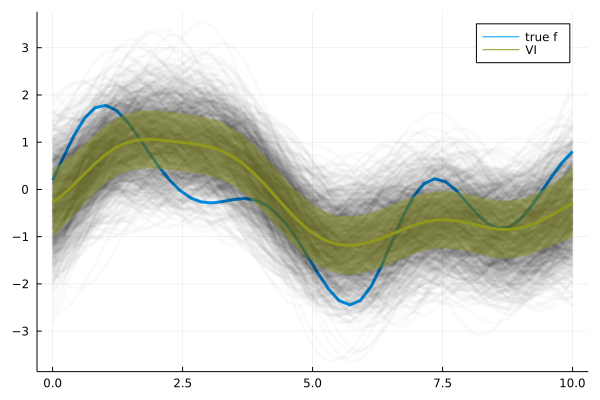

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

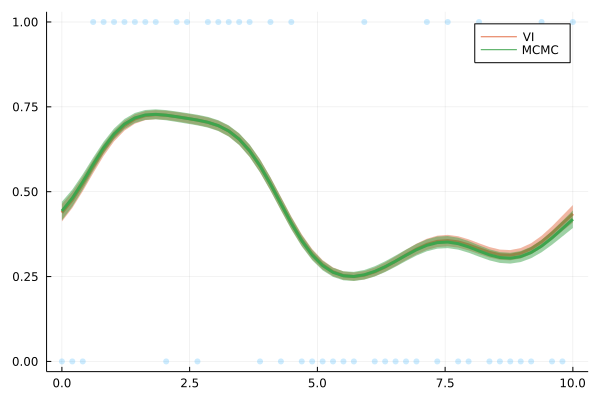

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*